# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [20]:
METRICS_PATH <- "./metrics/"

In [21]:
# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# install.packages(c('reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'zoo'))

Then, the dependencies

In [22]:
# To call python from R
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(zoo) # moving averages        

Load the the Python `integration.py` script to use its variable in R

In [23]:
#use_virtualenv('.venv/', required = TRUE)
# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python("definitions.py"))

Load the graph network as an adjancency matrix

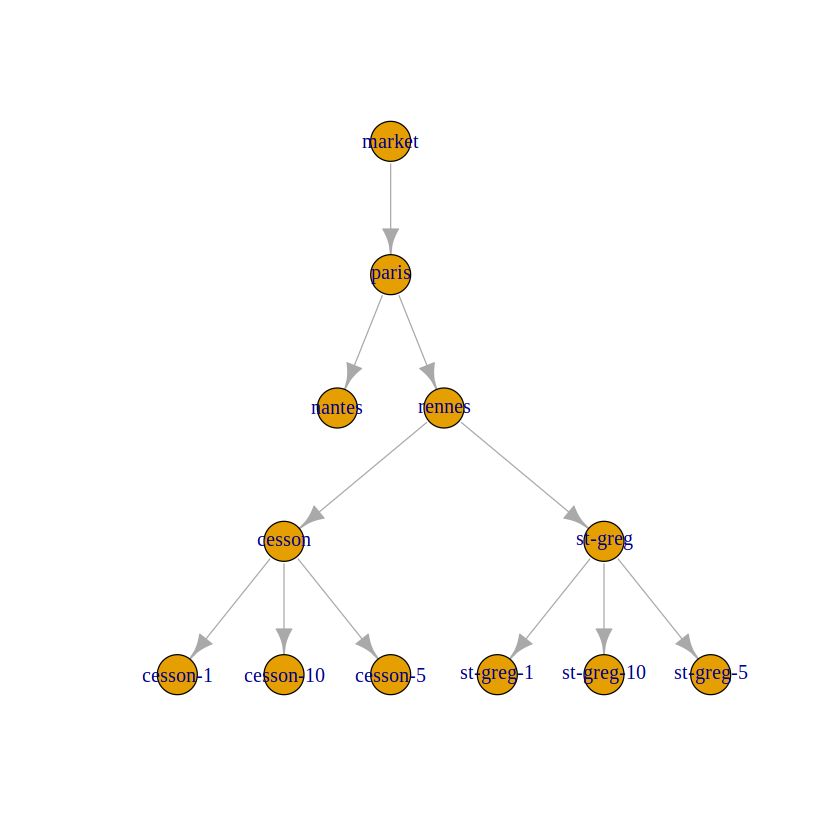

In [24]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret <- matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }
  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)
net <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
plot(net, layout = layout_as_tree)

# ceb <- cluster_edge_betweenness(g)
#
# dendPlot(ceb, mode="hclust")
# plot(ceb, g)

## Data preprocessing

In [25]:
names_raw <- read.csv2(file = paste(METRICS_PATH, "names.csv", sep = "/"), header = TRUE, sep = "\t")
names <- hashmap()
names[names_raw$instance] <- names_raw$name

missing <- data.frame(instance = names_raw$name, n = 0)

Load the names of the node and their correspondance in their IP on the virtual network

In [26]:
prepare <- function(x) {
  return(
    x %>%
      mutate(instance = names[instance]) %>%
      mutate(instance = as.character(instance)) %>%
      mutate(timestamp_raw = as.numeric(as.character(timestamp))) %>%
      mutate(timestamp = as.POSIXct(timestamp_raw, origin = "1970-01-01")) %>%
      mutate(value = as.numeric(as.character(value))) %>%
      merge(missing, all = TRUE) %>%
      arrange(instance)
  )
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [27]:
mem <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  distinct(instance, value, .keep_all = TRUE) %>%
  select(c(instance, value)) %>%
  mutate(dyn = formattable::percent(value / max(value, na.rm = TRUE))) %>%
  mutate(value = as.numeric(as.character(value)))

cpu <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_used.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  select(c(instance, value)) %>%
  distinct(instance, value, .keep_all = TRUE) %>%
  group_by(instance) %>%
  mutate(value = as.numeric(as.character(value)))

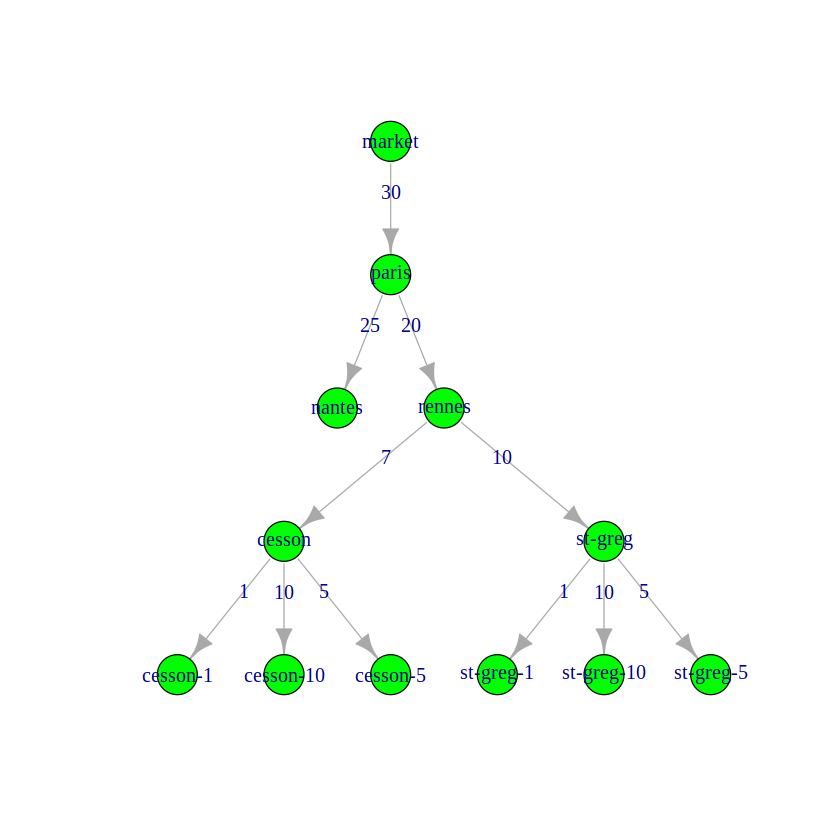

In [28]:
PercentageColourConnected <- function(x) {
  colorRampPalette(c("red", "green"))(2)[ifelse(is.na(x), 1, 2)]
}
net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_connected)$color <- PercentageColourConnected(mem$value)
plot(net_connected, layout = layout_as_tree, edge.label = E(net_connected)$weight)

instance,n
<chr>,<int>
cesson,4
cesson-1,4
cesson-10,4
cesson-5,4
market,34
nantes,16
paris,34
rennes,19
st-greg,7


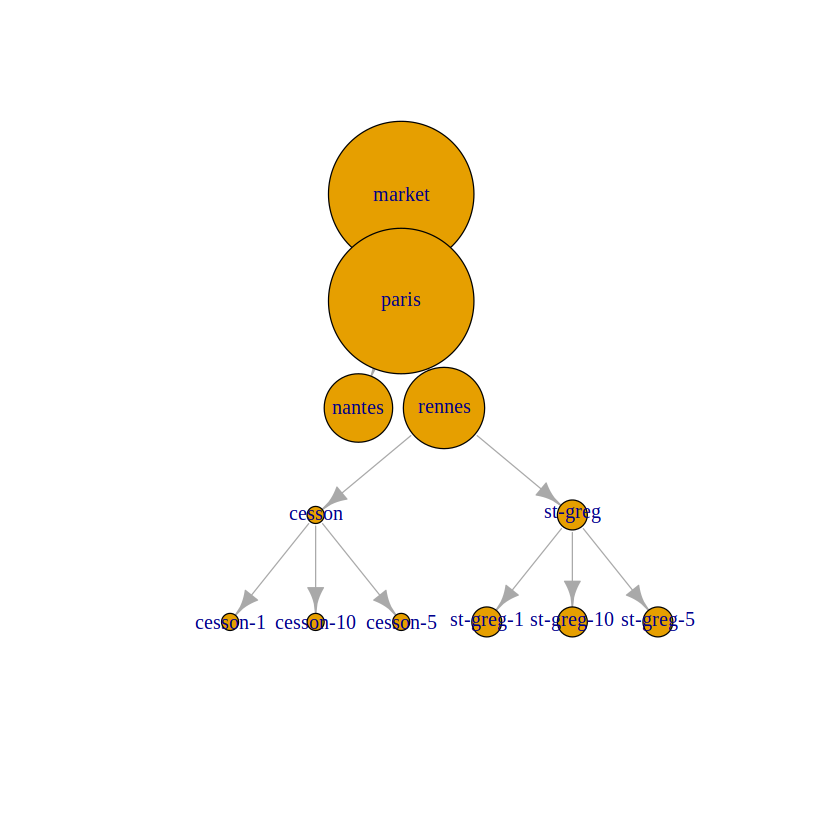

In [29]:
bids_raw <- read.csv2(file = paste(METRICS_PATH, "fog_node_bids.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

bids_won_raw <- bids_raw %>%
  select(c(instance, function_name, value))

bids_won_all_zero <- data.frame(instance = names_raw$name, n = 0)
bids_won <- bids_won_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  group_by(instance) %>%
  summarise(n = n())

bids_won

# Add missing participants and put them at 0
bids_won <- bids_won %>%
  merge(bids_won_all_zero, all = TRUE) %>%
  group_by(instance) %>%
  summarise(across(everything(), sum)) %>%
  arrange()

net_won <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_won)$size <- bids_won$n * 2
plot(net_won, layout = layout_as_tree)

Plot the free cpu

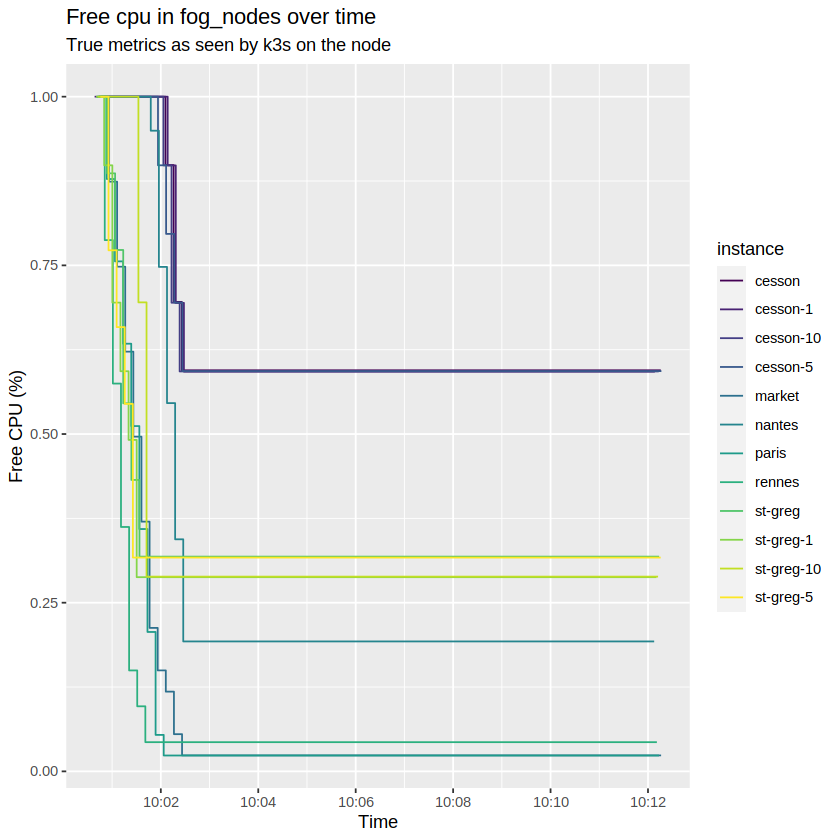

In [30]:
cpu_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
cpu_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

cpu_free <- cpu_used %>%
  inner_join(cpu_avail, by = c("instance", "timestamp")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

cpu_free %>%
ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  geom_step() +
  # geom_point() +
  labs(x = "Time", y = "Free CPU (%)", title = "Free cpu in fog_nodes over time", subtitle = "True metrics as seen by k3s on the node") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Plot the free memory

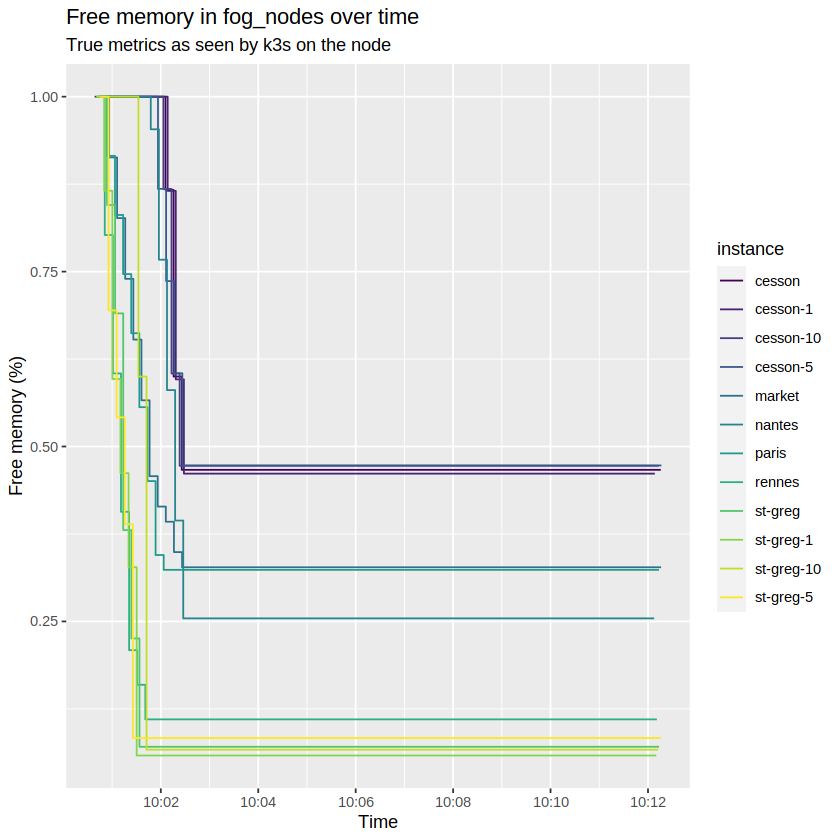

In [31]:
mem_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
mem_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

mem_free %>%
  ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  geom_step() +
  # geom_point() +
labs(x = "Time", y = "Free memory (%)", title = "Free memory in fog_nodes over time", subtitle = "True metrics as seen by k3s on the node") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

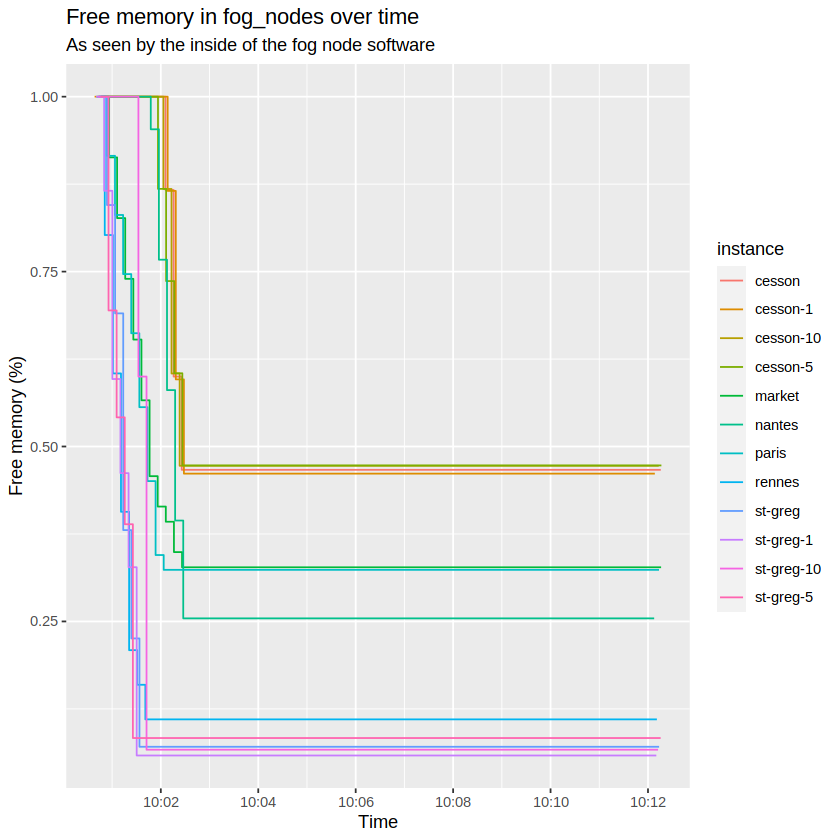

In [32]:
mem_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
mem_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

mem_free %>%
  ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  geom_step() +
  # geom_point() +
  labs(x = "Time", y = "Free memory (%)", title = "Free memory in fog_nodes over time", subtitle = "As seen by the inside of the fog node software")

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

In [33]:
latency <- read.csv2(file = paste(METRICS_PATH, "fog_node_neighbors_latency_rolling_avg.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  mutate(instance_to = as.character(names[instance_to]))

# latency %>%
#   group_by(instance, instance_to) %>%
#   summarize(mean_ms = round(median(value*1000), 0))

p <- c(.01, .1, 0.95, 0.99, 0.999, 1)
p_names <- map_chr(p, ~paste0(.x*100, ""))
p_funs <- map(p, ~partial(quantile, probs = .x, na.rm = TRUE)) %>% 
  set_names(nm = p_names)

quantiles <- latency %>%
    mutate(value = value*1000) %>%
    group_by(instance, instance_to) %>%
    summarize_at(vars(value), funs(!!!p_funs))
print(quantiles)

# quantiles <- within(quantiles, 
#                    latency <- factor(latency, 
#                                       levels=names(sort(table(as.numeric(latency)), 
#                                                         decreasing=TRUE))))
# quantiles <- within(quantiles, 
#                    quantile <- factor(quantile, 
#                                       levels=names(sort(table(as.numeric(quantile)), 
#                                                         decreasing=TRUE))))
# print(quantiles)

# print(
#   quantiles %>%
#     arrange(desc(as.numeric(latency))) %>%
#     ggplot(
#       aes(
#         x = latency,
#         y = value,
#         fill = quantile,
#       )
#     ) +
#     geom_col(position="dodge") +
#     scale_y_continuous(trans='sqrt') + 
#     labs(
#       x = "Ping latencies between hosts",
#       y = "Avg observed lat. (s) by quantiles",
#       title = "Latency between edge and the function.",
#       subtitle = paste("Color maches the quantile")
#     ) +
#     scale_color_viridis(discrete = TRUE, option = "D") +
#     scale_fill_viridis(discrete = TRUE)
# )


# latency %>%
#   ggplot(aes(x = timestamp, y = value, color = instance_to)) +
# geom_smooth() +
#   labs(x = "Time", y = "Latency (s)", title = "Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
#   scale_y_continuous(trans='sqrt') + 
#   facet_grid(rows = vars(instance))+
#   scale_color_viridis(discrete = TRUE, option = "D") +
  # scale_fill_viridis(discrete = TRUE) 

# latency %>%
#   ggplot(aes(x = timestamp, y = value, color = instance_to)) +
# geom_point() +
#   labs(x = "Time", y = "Latency (s)", title = "Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
#   scale_color_viridis(discrete = TRUE, option = "D") +
#   scale_fill_viridis(discrete = TRUE) 

# latency %>% group_by(instance, instance_to) %>% mutate(median = median(value)) %>%
#   ggplot(aes(x = instance, y = median, color = instance_to)) +
#   geom_point() +
#   # scale_y_continuous(trans='sqrt') + 
#   labs(x = "Source", y = "Latency (s)", title = "Max latency from a node to its neighbors") +
#   # facet_grid(rows = vars(instance_to))+
#   scale_color_viridis(discrete = TRUE, option = "D") +
#   scale_fill_viridis(discrete = TRUE) 

# A tibble: 22 × 8
# Groups:   instance [12]
   instance  instance_to   `1`  `10`  `95`   `99` `99.9`  `100`
   <chr>     <chr>       <dbl> <dbl> <dbl>  <dbl>  <dbl>  <dbl>
 1 cesson    cesson-1      2.5   2.5   2.5    4      4      4  
 2 cesson    cesson-10    20.5  20.5  20.8   21     21     21  
 3 cesson    cesson-5     10.5  10.5  10.5   10.8   10.8   10.8
 4 cesson    rennes       30.5  30.5  30.7   31.5   31.8   31.8
 5 cesson-1  cesson        2.5   2.5   3   3754   3754   3754  
 6 cesson-10 cesson       20.5  20.5  20.5 7647.  7647.  7647. 
 7 cesson-5  cesson       10.5  10.5  11   7605   7605   7605  
 8 market    paris        60.5  60.5  61     61     61     61  
 9 nantes    paris        50.5  50.5  51     51     51     51  
10 paris     market       39    39.5  61   4655.  4655   4655  
# … with 12 more rows


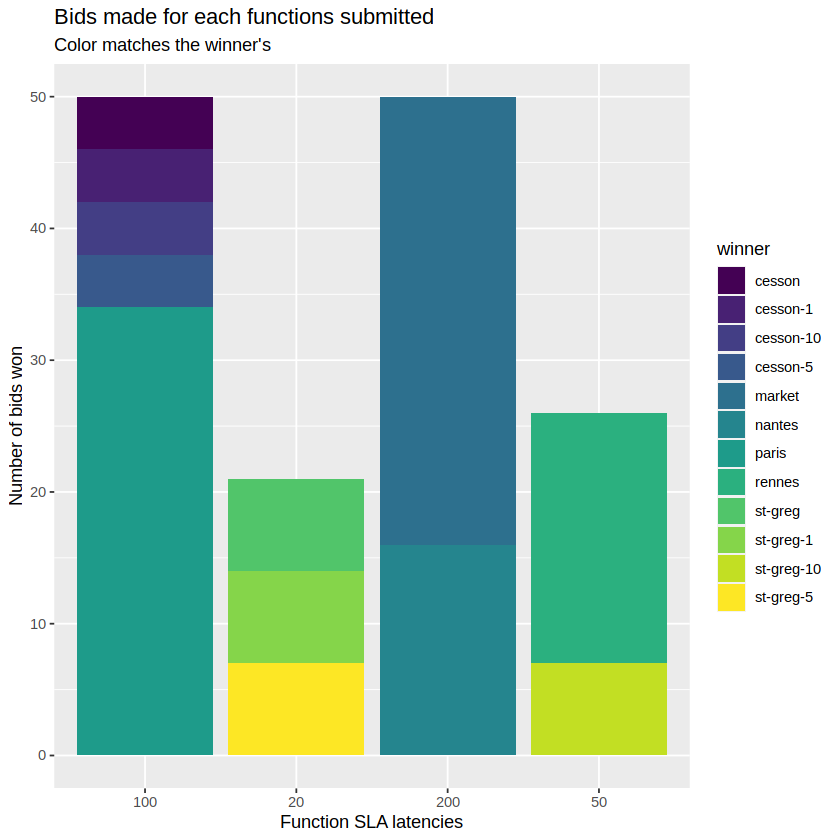

In [34]:
bids_won_function <- bids_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  mutate(winner = instance)

# head(bids_won_function)

bids_function <- bids_raw %>%
  mutate(winner = instance) %>%
  select(instance, function_name, value) %>%
  distinct() %>%
  mutate(latency = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[, 4]) %>%
  inner_join(bids_won_function, by = c("function_name"))

# head(bids_function)

bids_function %>%
    group_by(winner, latency, function_name) %>%
    arrange(desc(as.numeric(latency))) %>%   
    select(winner, latency, function_name) %>%
    distinct() %>%
    ggplot(
      aes(
        x = latency,
        fill = winner,
      )
    ) +
  geom_bar() +
  labs(x = "Function SLA latencies", y = "Number of bids won", title = "Bids made for each functions submitted", subtitle = "Color matches the winner's")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

winner,function_name,value
<chr>,<chr>,<dbl>
paris,echo--001--100--400--300,0.003438045
rennes,echo--002--50--400--300,0.013765754
st-greg-5,echo--003--20--400--300,0.084660467
market,echo--004--200--400--300,0.003453266
paris,echo--005--100--400--300,0.003527631
rennes,echo--006--50--400--300,0.014469961


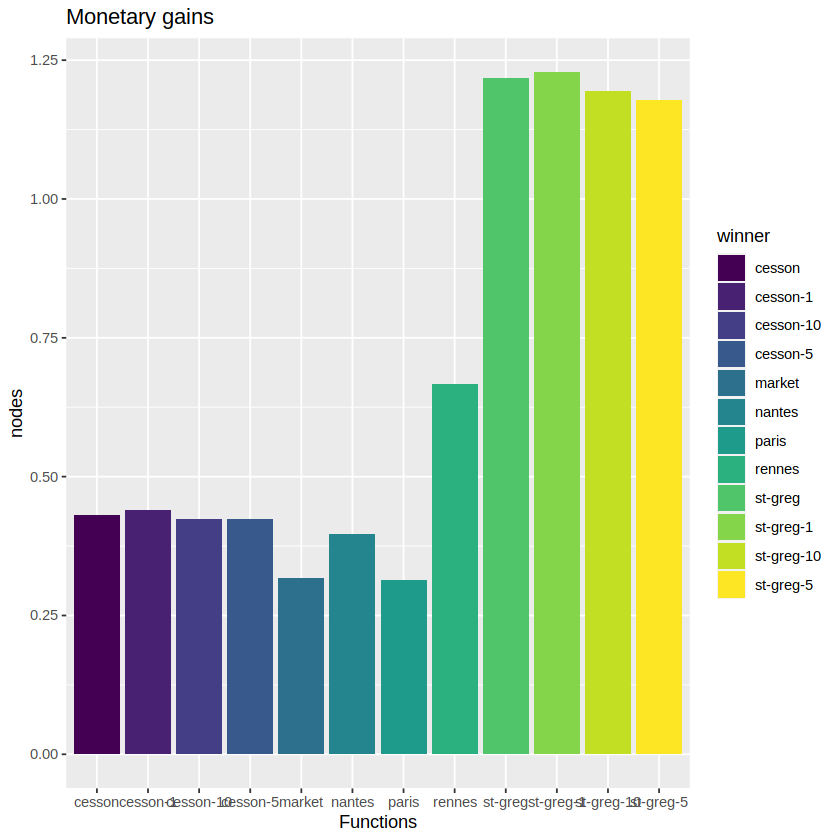

In [35]:
winner_gains <- bids_won_function %>%
  select(c(winner, function_name, value)) %>%
  distinct()
head(winner_gains)

winner_gains %>%
  ggplot(aes(x = winner, y = value, fill = winner)) +
  geom_col() +
  labs(x = "Functions", y = "nodes", title = "Monetary gains")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

instance,job,timestamp,tag,period,value.x,value.y,diff_x,diff_y,new_avg,function_name,latency,index,winner,break_sla
<chr>,<chr>,<dttm>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>
NULL,telegraf,2023-01-12 10:03:38,echo--001--100--400--300,100,6.969,134,5.116,100,0.05116,echo--001--100--400--300,100,001,paris,FALSE
NULL,telegraf,2023-01-12 10:03:38,echo--001--100--400--300,100,6.969,134,5.116,100,0.05116,echo--001--100--400--300,100,001,paris,FALSE
NULL,telegraf,2023-01-12 10:03:38,echo--001--100--400--300,100,6.969,134,5.116,100,0.05116,echo--001--100--400--300,100,001,paris,FALSE
NULL,telegraf,2023-01-12 10:03:38,echo--001--100--400--300,100,6.969,134,5.116,100,0.05116,echo--001--100--400--300,100,001,paris,FALSE
NULL,telegraf,2023-01-12 10:03:38,echo--001--100--400--300,100,6.969,134,5.116,100,0.05116,echo--001--100--400--300,100,001,paris,FALSE
NULL,telegraf,2023-01-12 10:03:38,echo--001--100--400--300,100,6.969,134,5.116,100,0.05116,echo--001--100--400--300,100,001,paris,FALSE


latency,period,quantile,value
<fct>,<int>,<fct>,<dbl>
100,100,95,1.479119
100,100,99,1.915371
100,100,99.9,2.089613
100,100,100,2.124469
20,100,95,1.420194
20,100,99,1.788086


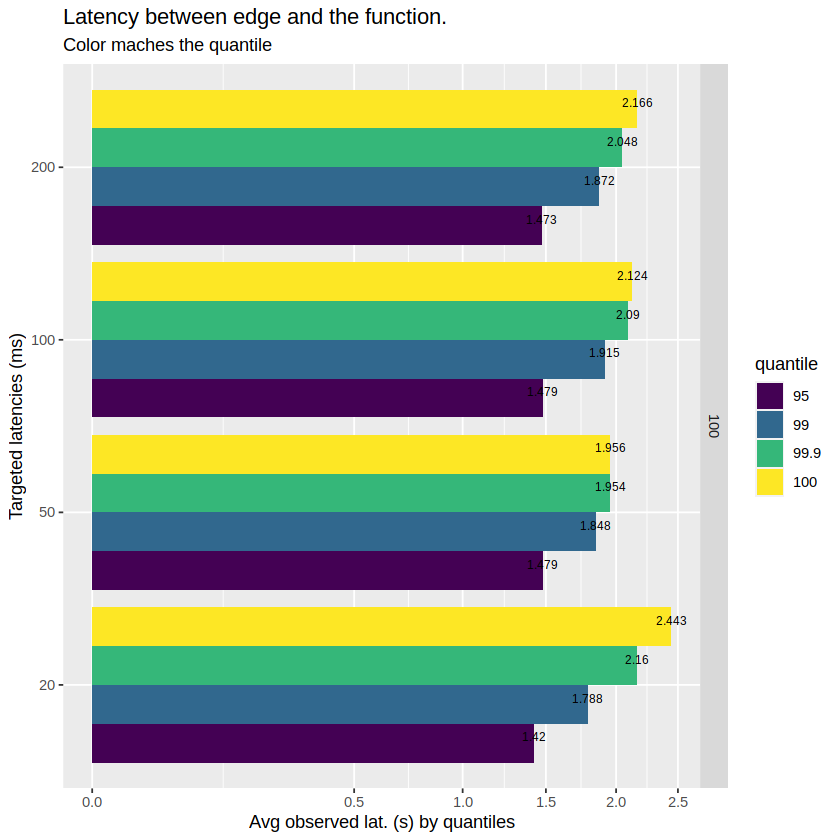

In [36]:
echo_sum <-
  read.csv2(file = "metrics/iot_emulation_http_request_to_processing_echo_duration_seconds_print_sum.csv", header = TRUE, sep = "\t") %>%
  prepare()

echo_count <-
  read.csv2(file = "metrics/iot_emulation_http_request_to_processing_echo_duration_seconds_print_count.csv", header = TRUE, sep = "\t") %>%
  prepare()

latencies <- echo_sum %>%
  mutate(latency = stringr::str_match(tag, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,4]) %>%
  select(latency) %>%
  distinct() %>%
  filter(!is.na(latency))

average <- echo_sum %>%
  inner_join(echo_count,
             by = c("instance", "job", "timestamp", "timestamp_raw", "tag", "period"),
  ) %>%
  select(instance, job, timestamp, tag, period, value.x, value.y) %>%
  drop_na() %>%
  group_by(instance, job, tag, period) %>%
   arrange(timestamp, instance, job, tag, period,
        desc(timestamp)
    ) %>%
  mutate(diff_x = value.x - dplyr::lag(value.x, order_by = timestamp))%>%
  mutate(diff_y = value.y - dplyr::lag(value.y, order_by = timestamp))%>%
  mutate(new_avg = diff_x  / diff_y) %>%
  drop_na() %>%
  mutate(function_name = tag) %>%
  mutate(latency = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,4]) %>%
  mutate(index = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,3]) %>%
  inner_join(bids_function %>% select(function_name, winner),by = c("function_name")) %>%
  mutate(break_sla = new_avg >= as.numeric(latency) / 1000)

head(average)

p <- c(0.95, 0.99, 0.999, 1)
p_names <- map_chr(p, ~paste0(.x*100, ""))
p_funs <- map(p, ~partial(quantile, probs = .x, na.rm = TRUE)) %>% 
  set_names(nm = p_names)

quantiles <- average %>%
    # mutate(period = as.character(period)) %>%
    group_by(latency, period) %>%
    # select(latency, period, new_avg)  %>%
    summarize_at(vars(new_avg), funs(!!!p_funs)) %>%
    pivot_longer(cols = -c("latency", "period"), names_to = c("quantile"))

quantiles <- within(quantiles, 
                   latency <- factor(latency, 
                                      levels=names(sort(table(as.numeric(latency)), 
                                                        decreasing=TRUE))))
quantiles <- within(quantiles, 
                   quantile <- factor(quantile, 
                                      levels=names(sort(table(as.numeric(quantile)), 
                                                        decreasing=TRUE))))
head(quantiles)

print(
  quantiles %>%
    arrange(desc(as.numeric(latency))) %>%
    ggplot(
      aes(
        x = latency,
        y = value,
        fill = quantile,
        label = round(value, 3),
      )
    ) +
    geom_col(position="dodge") +
    coord_flip() +
    scale_y_continuous(trans='sqrt') + 
    geom_text(vjust = -0.2, position=position_dodge(width=0.9), size=2.5) +
    labs(
      x = "Targeted latencies (ms)",
      y = "Avg observed lat. (s) by quantiles",
      title = "Latency between edge and the function.",
      subtitle = paste("Color maches the quantile")
    ) +
    facet_grid(rows = vars(period), scales = "free") +
    scale_color_viridis(discrete = TRUE, option = "D") +
    scale_fill_viridis(discrete = TRUE)
)

`summarise()` has grouped output by 'latency', 'period', 'winner'. You can override
using the `.groups` argument.


latency,period,winner,n,broken,total,percent_per_winner
<fct>,<int>,<chr>,<int>,<int>,<int>,<dbl>
100,100,cesson,15096,192,808,0.01271860
100,100,paris,15096,3367,14288,0.22303922
20,100,st-greg,3093,260,1032,0.08406078
20,100,st-greg-1,3093,247,978,0.07985774
20,100,st-greg-5,3093,273,1083,0.08826382
200,100,market,22276,4044,17307,0.18154067


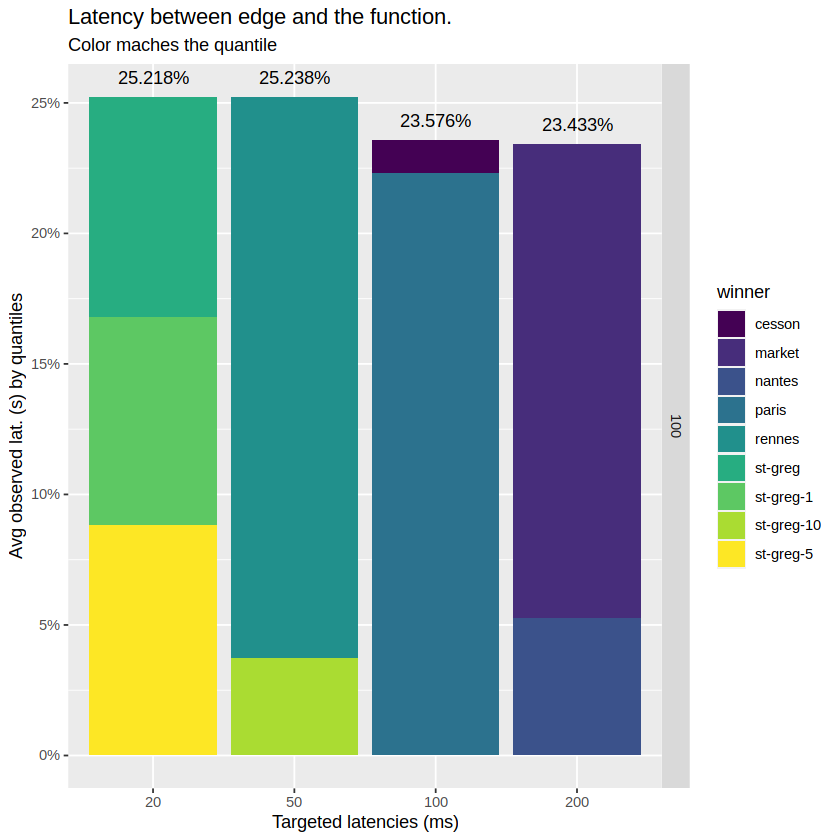

In [179]:
sla_breaks <- average %>%
    group_by(latency, period, winner) %>%
    select(latency, period, winner, break_sla) %>%
    group_by(latency, period) %>%
    add_count() %>%
    # mutate(percent = sum(break_sla, na.rm=TRUE) / n) %>%
    group_by(latency, period, winner, n) %>%
    summarize(broken = sum(break_sla, na.rm=TRUE), total = n()) %>%
    mutate(percent_per_winner = broken / n) %>%
    {.}

sla_breaks <- within(sla_breaks, 
                   latency <- factor(latency, 
                                      levels=names(sort(table(as.numeric(latency)), 
                                                        decreasing=TRUE))))

head(sla_breaks)

print(
  sla_breaks %>%
    group_by(latency) %>%
    arrange(desc(as.numeric(latency))) %>%
    ggplot(
      aes(
        x = latency,
        group = winner,
        y = percent_per_winner,
        fill = winner,
        # label = scales::percent(percent_per_winner)
      )
    ) +
    geom_col() +
    geom_text(aes(label = after_stat(scales::percent(y)), group = latency), 
        stat = 'summary', fun = sum, vjust = -1
      ) +
    scale_y_continuous(labels=scales::percent) +
    labs(
      x = "Targeted latencies (ms)",
      y = "Avg observed lat. (s) by quantiles",
      title = "Latency between edge and the function.",
      subtitle = paste("Color maches the quantile")
    ) +
    facet_grid(rows = vars(period), scales = "free") +
    scale_color_viridis(discrete = TRUE, option = "D") +
    scale_fill_viridis(discrete = TRUE)
)
